# Data and Model Drift Detection for Tabular Data

The environment of our world is constantly changing. For machine learning, this means that deployed models are confronted with unknown data and can become outdated over time. A proactive drift management approach is required to ensure that productive AI services deliver consistent business value in the long term. Check out our background article [Getting traction on Data and Model Drift with Azure Machine Learning](https://medium.com/p/ebd240176b8b/edit) for an in-depth discussion about key concepts.

This notebook provides the following mechanisms to detect and mitigate data and model drift:

- Retrieve sample datasets from CSV files and managed AML datasets
- Statistical tests and expressive visualizations to detect and analyze drift in features and model predictions
- Predictive approach to identify the impact of data and concept drift on the model
- Create automated pipelines to identify data drift regularly as part of an MLOps solution using Azure Machine Learning

The notebook was developed and tested using the ``Python 3.8-AzureML`` kernel on a Azure ML Compute Instance.

# Setup

In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import pandas as pd
import numpy as np
import os

from scipy.stats import ks_2samp, chisquare, chi2_contingency, gaussian_kde
#!pip install scikit-learn --upgrade
import sklearn
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from lightgbm import LGBMClassifier

from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient, Input
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component

os.chdir("../")
print(os.getcwd())
from utils import *

The scikit-learn version is 1.1.1.
/mnt/batch/tasks/shared/LS_root/mounts/clusters/natashasavic2/code/Users/natashasavic/data-model-drift/tabular-data


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# Read and prepare data for drift analysis

We are using a synthetic predictive maintenance dataset for demonstration. The goal is to predict if a production engine will fail. We have the following features available: 
- timestamp
- heat_deviation
- speed_deviation
- assembly_line_num
- days_since_last_service
- sensor_back
- sensor_front
- operator

The binary target variable failure reflects whether the machine working properly (0) or is in failure state (1).


Since we assume that data drift impacted the dataset over time, we split the data into two consecutive windows, **reference** and **current**:

<img src="../media/data-reference-current.png" alt="Illustration of model drift detecion concepts" width="800"/>

For real world drift detection, it is recommended to try different splits (sizes of the current window).

Note that we also define a third window called "test" which is used later for the predictive model drift analysis. It is not required for data drift analysis.

In [2]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

# Retrieve an already attached Azure Machine Learning Compute.
cluster_name = "cpu-cluster"
print(ml_client.compute.get(cluster_name))

Found the config file in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/natashasavic2/code/Users/natashasavic/.azureml/config.json


AmlCompute({'type': 'amlcompute', 'created_on': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'name': 'cpu-cluster', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/3a0dc8b1-97e1-4225-b97e-ab8bacd270f6/resourceGroups/NetworkWatcherRG/providers/Microsoft.MachineLearningServices/workspaces/Natasha_ANZ/computes/cpu-cluster', 'source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/natashasavic2/code/Users/natashasavic/data-model-drift/tabular-data', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x7fe2ec52b9d0>, 'resource_id': None, 'location': 'australiaeast', 'size': 'STANDARD_DS11_V2', 'min_instances': 0, 'max_instances': 2, 'idle_time_before_scale_down': 120.0, 'identity': None, 'ssh_public_access_enabled': True, 'ssh_settings': None, 'network_settings': None, 'tier': 'dedicated'})


## Build the environment

Us this command to build the environment. If you need to make changes, make sure to update the environment and add a new version

`az ml environment create --name data-model-drift-env --version 1 --file conda_image_docker.yml --conda-file conda_yamls/env_cli.yml --resource-group NetworkWatcherRG --workspace-name Natasha_ANZ`


In [6]:
parent_dir = os.getcwd()
prep_yml = "/SDK-V2/prep_data.yml"
drift_yml = "/SDK-V2/data_drift.yml"


# 1. Load components
prepare_data = load_component(path=f"{parent_dir}{prep_yml}")
measure_data_drift = load_component(f"{parent_dir}{drift_yml}")


# 2. Construct pipeline
@pipeline()
def data_drift_preprocess(pipeline_job_input):
    # the parameters come from the respectove .yml file step. E.g. "input_path" is under inputs
    transform_data = prepare_data(input_path=pipeline_job_input)
    # the input for this pipeline is the output of the previous pipeline which is called "output_path"
    drift_detect = measure_data_drift(
        tansformed_data_path=transform_data.outputs.output_path,
        threshold = 0.01

    )
    return {
        "pipeline_job_prepped_data": transform_data.outputs.output_path,
        "pipeline_job_detect_data_drift": drift_detect.outputs.drift_plot_path,
    }

pipeline_job = data_drift_preprocess(
    Input(type="uri_folder", path=parent_dir + "/data/data_raw/predictive_maintenance")
)
# demo how to change pipeline output settings
pipeline_job.outputs.pipeline_job_prepped_data.mode = "upload" # "rw_mount"
pipeline_job.outputs.pipeline_job_detect_data_drift.mode = "upload" # "rw_mount"

# set pipeline level compute
pipeline_job.settings.default_compute="cpu-cluster"
# set pipeline level datastore
pipeline_job.settings.default_datastore="workspaceblobstore"

In [7]:
# submit job to workspace
experiment_name = "data_drift_experiment"

pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name=experiment_name
)
pipeline_job

Uploading prep_src (0.0 MBs): 100%|██████████| 4392/4392 [00:00<00:00, 71504.64it/s]




Experiment,Name,Type,Status,Details Page
data_drift_experiment,clever_ear_gj409y5d24,pipeline,Preparing,Link to Azure Machine Learning studio


In [39]:
dataset = pd.read_csv("./data/data_raw/predictive_maintenance_update.csv")

dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

# Define timestamps for splitting
current_start = pd.to_datetime("01/06/2021")
test_start = pd.to_datetime("01/06/2022")

reference = dataset[dataset["timestamp"] <= current_start]
current = dataset[(dataset["timestamp"] >= current_start) & (dataset["timestamp"] < test_start)]
test = dataset[dataset["timestamp"] >= test_start]

# Sanity checking
print("reference min: ", reference["timestamp"].min(), " reference max: ", reference["timestamp"].max())
print("current min: ", current["timestamp"].min(), " current max: ", current["timestamp"].max())
print("test min: ", test["timestamp"].min(), " test max: ", test["timestamp"].max())

reference min:  2020-01-06 00:24:38  reference max:  2021-01-05 23:50:54
current min:  2021-01-06 00:16:07  current max:  2022-01-05 23:02:33
test min:  2022-01-06 00:00:10  test max:  2022-01-08 23:59:09


# Data and Target Drift Analysis
For the statistical tests, numerical and categorical data will undergo distinct non-parametric tests that provide a p-value:
- **KS Test** for continuous data: What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?
- **Chi Square Test** for categorical data: Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table

Those tests allow us to accept or reject the null hypothesis with a degree of confidence, as defined by the p-value. As such, you can control the sensitivity of the test by adjusting the threshold for the p-value. We recommend a more conservative p-value such as 0.01 by default.

While statistical tests are useful to identify drift, it is hard to interpret the magnitude of the drift as well as in which direction it occurs. Given a variable like age, did the sample get older or younger and how is the age spread? To answer those questions, it is useful to visualize the distributions. For this, we add another non-parametric method: the Kernel Density Estimation (KDE).

## Specify Data Drift Analysis

In [41]:
# flag a variable as drifted if p-value is below the threshold
threshold = 0.01

# option to use shortlist of relevant columns
#shortlist = ['heat_deviation', 'speed_deviation', 'days_since_last_service', 'sensor_back', 'sensor_front', 'assembly_line_num', 'operator',  'failure']

# shortlist = [] # if no shortlist present 

# use shortlist if exists, else all columns from reference
columns = list(reference.columns) #if shortlist == [] else shortlist

# identify numerical and categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(reference[columns])
categorical_columns = categorical_columns_selector(reference[columns])
   
# label encoding for plots of categorical columns
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

reference_le = categorical_transformer.fit_transform(reference[categorical_columns])
reference_le = pd.DataFrame(reference_le)
reference_le.columns = categorical_columns

current_le = categorical_transformer.transform(current[categorical_columns])
current_le = pd.DataFrame(current_le)
current_le.columns = categorical_columns

# impute missing values

if categorical_columns != []:

    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    current_le = imp_mode.fit_transform(current_le[categorical_columns])
    current_le = pd.DataFrame(current_le)
    current_le.columns = categorical_columns

    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    reference_le = imp_mode.fit_transform(reference_le[categorical_columns])
    reference_le = pd.DataFrame(reference_le)
    reference_le.columns = categorical_columns

In [14]:
print(f'numerical columns: {numerical_columns}')
print(f'categorical columns: {categorical_columns}')

numerical columns: ['timestamp', 'heat_deviation', 'speed_deviation', 'days_since_last_service', 'sensor_back', 'sensor_front', 'failure']
categorical columns: ['assembly_line_num', 'operator']


## Viualize Results

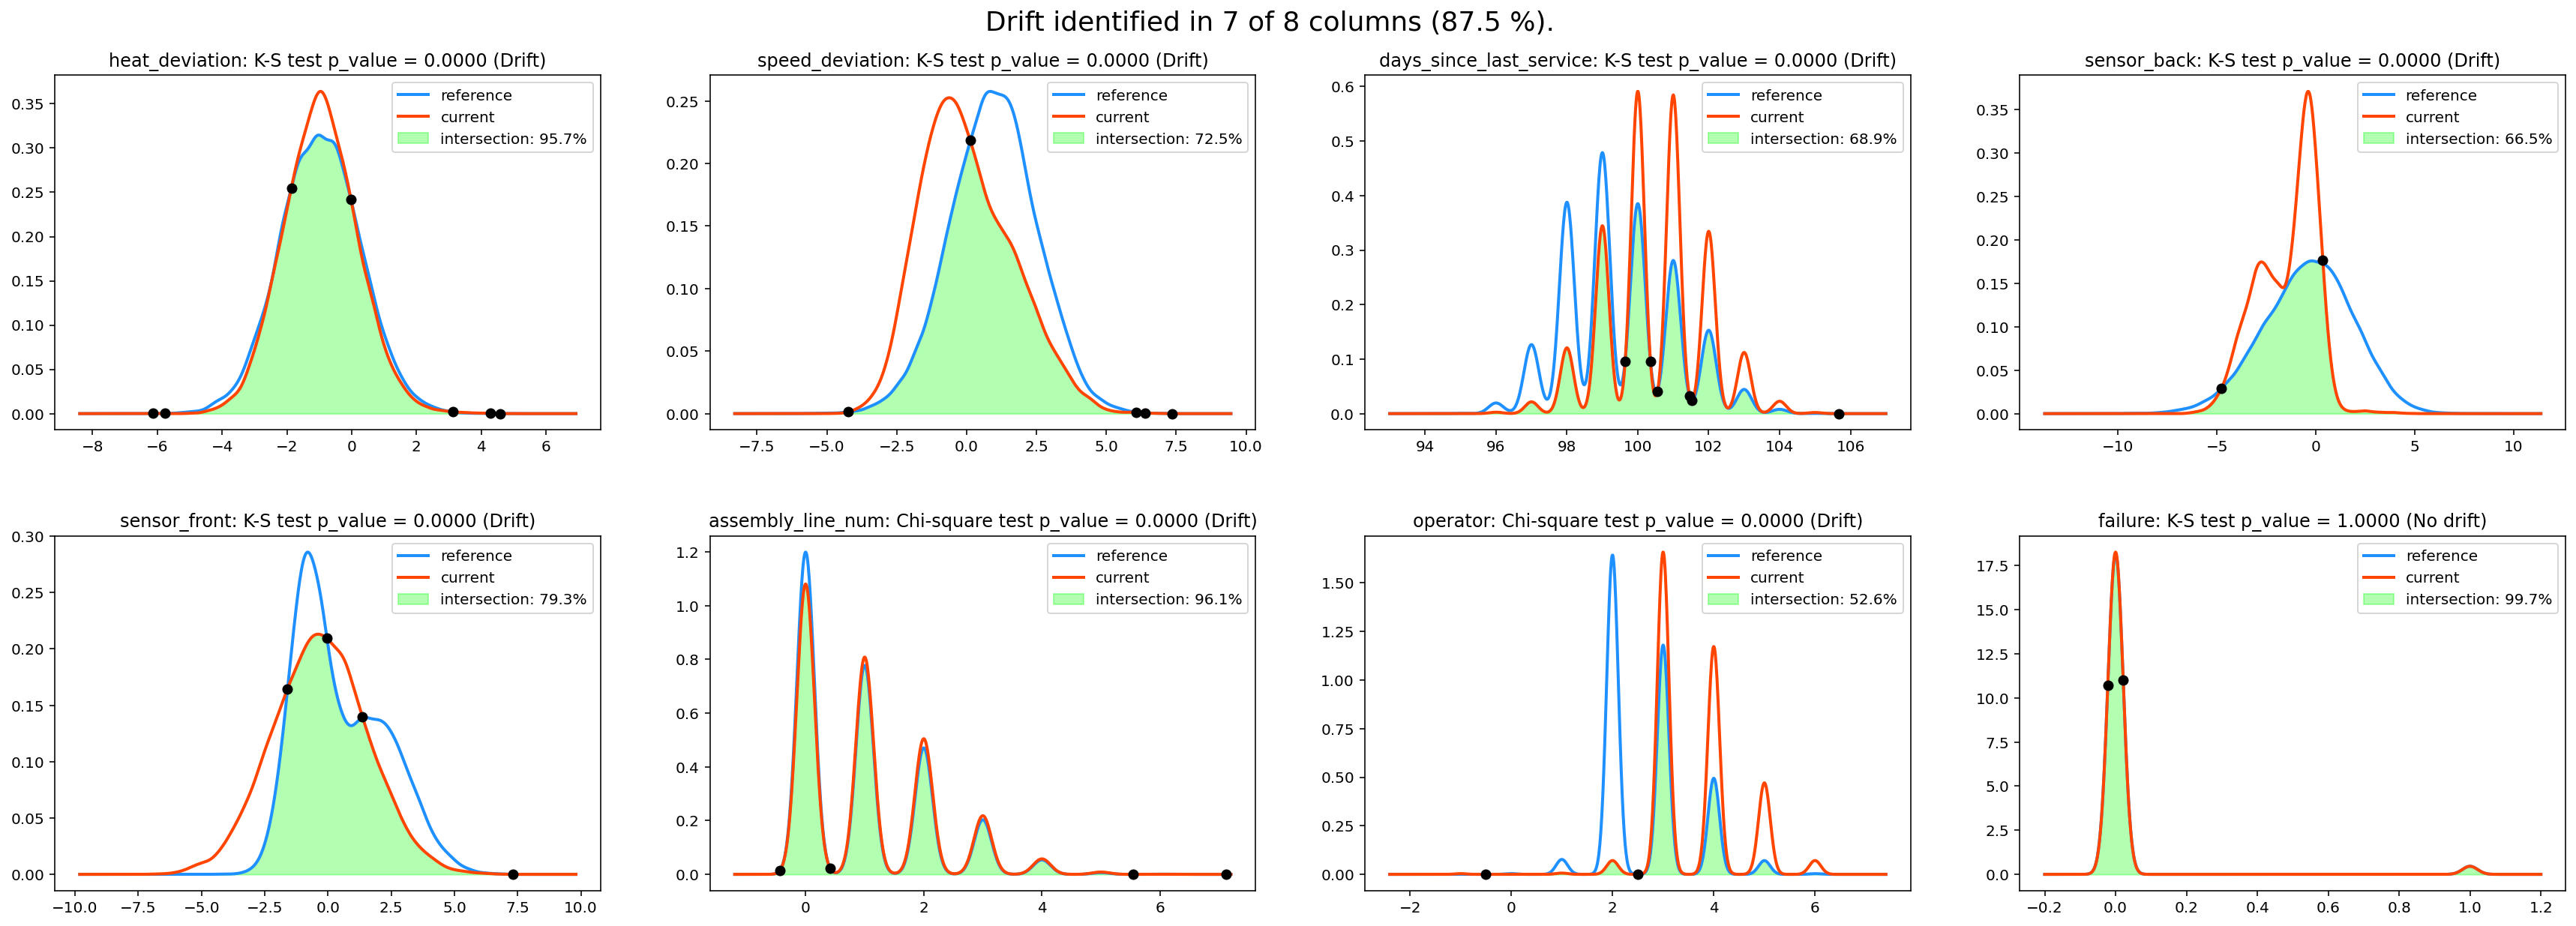

In [11]:
# prepare plot
total = len(columns)
display_cols = 4

rows = total // display_cols
rows += total % display_cols
position = range(1, total + 1)

fig = plt.figure(figsize=(30, 5 * rows))
fig.subplots_adjust(hspace= 0.3, wspace=0.2)

drift_cols = 0
for k, col in enumerate(columns):
    
    if col in numerical_columns:
        
        # statistical test:
        statistic, p_value = ks_2samp(reference[col].values, current[col].values)
        if p_value < threshold:
            drift_indication = 'Drift'
            drift_cols += 1
        else:
            drift_indication = 'No drift'
        annot = f'{col}: K-S test p_value = {p_value:.4f} ({drift_indication})'
        
        # plot:
        ref_arr = np.sort(reference[col])
        curr_arr = np.sort(current[col])

        # add noise to enable plotting when constant values present
        ref_arr = add_noise_to_constant(A=curr_arr, B=ref_arr) #this assumes the reference distribution is a constant
        curr_arr = add_noise_to_constant(A=ref_arr, B=curr_arr) #this assumes the current distribution is a constant

        ax = fig.add_subplot(rows, display_cols, position[k])
        try: 
            plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
        except Exception as e:
            annot = f'{col} - {e}'
            print(annot)

        ax.set_title(annot)
       
    elif col in categorical_columns:
        
        # statistical test:
        observations = contingency_table(reference_le[col], current_le[col])
        statstic, p_value, dof, _ = chi2_contingency(observations)
        if p_value < threshold:
            drift_indication = 'Drift'
            drift_cols += 1
        else:
            drift_indication = 'No drift'
        annot = f'{col}: Chi-square test p_value = {p_value:.4f} ({drift_indication})'

        # plot:
        ref_arr = np.sort(reference_le[col])
        curr_arr = np.sort(current_le[col])

        # add noise to enable plotting when constant values present
        ref_arr = add_noise_to_constant(A=curr_arr, B=ref_arr) #this assumes the reference distribution is a constant
        curr_arr = add_noise_to_constant(A=ref_arr, B=curr_arr) #this assumes the current distribution is a constant

        ax = fig.add_subplot(rows, display_cols, position[k])
        
        try:
            plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
        except Exception as e:
            annot = f'{col} - {e}'
            print(annot)
        
        ax.set_title(annot)
        
    else:
        print('Columns type not recognized')

drift_stat = f'Drift identified in {drift_cols} of {len(columns)} columns ({drift_cols/len(columns) * 100:.1f} %).'
plt.suptitle(drift_stat, y=0.94, fontsize = 18)

plt.show()

# Predictive approach to identify the impact of data or concept drift on the model

Now that we have seen how to uncover drift in features and labels, let us find out if the model is affected by data or concept drift.
Similar as before, we stack the historical (training) observations and recent labeled datapoints together to a chronological dataset. Then, we compare model performance based on the most recent observations, as the following overview illustrates. 

<img src="../media/predicitve-drift-test.png" alt="Illustration of model drift detecion concepts" width="800"/>


At the core, we want to answer the question: Does a newer model perform better in predicting on most recent data than a model trained on older observations? 
We probably have no idea in advance if and where drift has crept in. 
Therefore, in our first attempt we might use the original training data as reference and the inference observations as current windows. If we find the existence of drift by this, we will likely try out different reference and current windows to pinpoint where exactly drift crept in.

Unlike for the statistical tests conducted above, all features of the dataset are used for training (no shortlist).

In [6]:
# creating refereence and current windows plus test set

X_reference, y_reference = reference.drop(['failure', 'timestamp'], axis=1), reference['failure']
X_current, y_current = current.drop(['failure', 'timestamp'], axis=1), current['failure']
X_test, y_test = test.drop(['failure', 'timestamp'], axis=1), test['failure']

## Create training pipeline

In [7]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_reference)
categorical_columns = categorical_columns_selector(X_reference)

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('standard_scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

## Fit on reference window 

In [9]:
from sklearn.metrics import roc_auc_score
 
reference_clf = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', LGBMClassifier())])

reference_clf.fit(X_reference, y_reference)
reference_pred = reference_clf.predict(X_test)
reference_probas = reference_clf.predict_proba(X_test)

print('Reference set classification report:')
print(classification_report(y_test, reference_pred, digits=4))
print("ROC AUC",round(roc_auc_score(y_test, reference_probas[:,1]), 3))

Reference set classification report:
              precision    recall  f1-score   support

           0     0.9739    0.9032    0.9372      4875
           1     0.0146    0.0560    0.0232       125

    accuracy                         0.8820      5000
   macro avg     0.4943    0.4796    0.4802      5000
weighted avg     0.9499    0.8820    0.9144      5000

ROC AUC 0.58


## Fit on current window

In [10]:
current_clf = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', LGBMClassifier())])

current_clf.fit(X_current, y_current)
current_pred = current_clf.predict(X_test)
current_probas = current_clf.predict_proba(X_test)

print('\nCurrent set classification report:')
print(classification_report(y_test, current_pred, digits=4))
print("ROC AUC", round(roc_auc_score(y_test, current_probas[:,1]), 3))


Current set classification report:
              precision    recall  f1-score   support

           0     0.9863    0.9327    0.9588      4875
           1     0.1590    0.4960    0.2408       125

    accuracy                         0.9218      5000
   macro avg     0.5727    0.7144    0.5998      5000
weighted avg     0.9657    0.9218    0.9408      5000

ROC AUC 0.775


The current model outperforms the reference model by a large margin. Therefore, we can conclude that we indeed have identified model drift and that the current model is a promising candidate for replacing the production model.

A visual way of inspection is to compare the distributions of confidence scores of both classifiers.

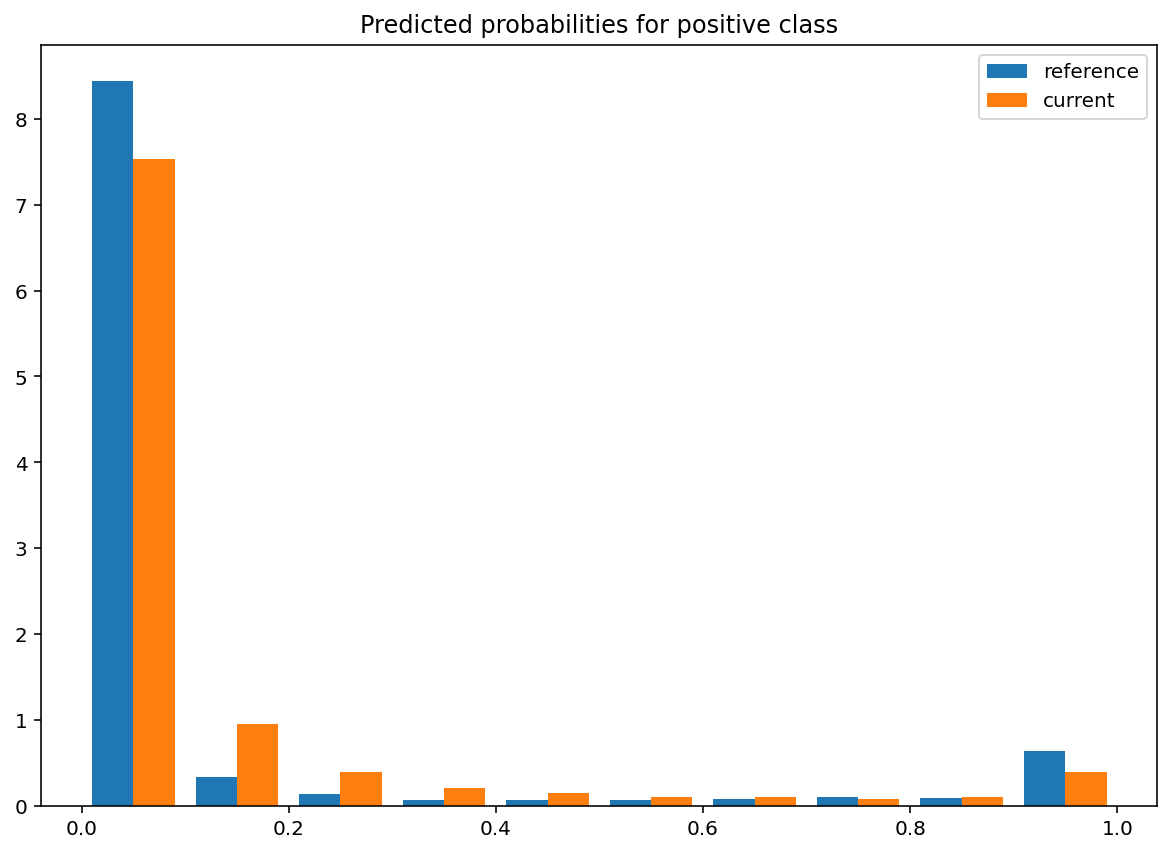

In [11]:
ref_arr = np.sort(reference_probas[:,1])
curr_arr = np.sort(current_probas[:,1])


fig, ax = plt.subplots(figsize=(10,7))
plt.hist([ref_arr, curr_arr], label=['reference', 'current'], density=True)
plt.legend(loc='upper right')
plt.title('Predicted probabilities for positive class')
plt.show()

The histograms on the show a clear difference between the predicted class probabilities of the reference and current models and therefore also confirm the existence of model drift.

In [12]:
statistic, p_value = ks_2samp(reference_probas[:,1], current_probas[:,1])
if p_value < threshold:
    drift_indication = 'Drift'
else:
    drift_indication = 'No drift'
annot = f'Probability distribution of positive class: K-S test p_value = {p_value:.4f} ({drift_indication})'
print(annot)

Probability distribution of positive class: K-S test p_value = 0.0000 (Drift)


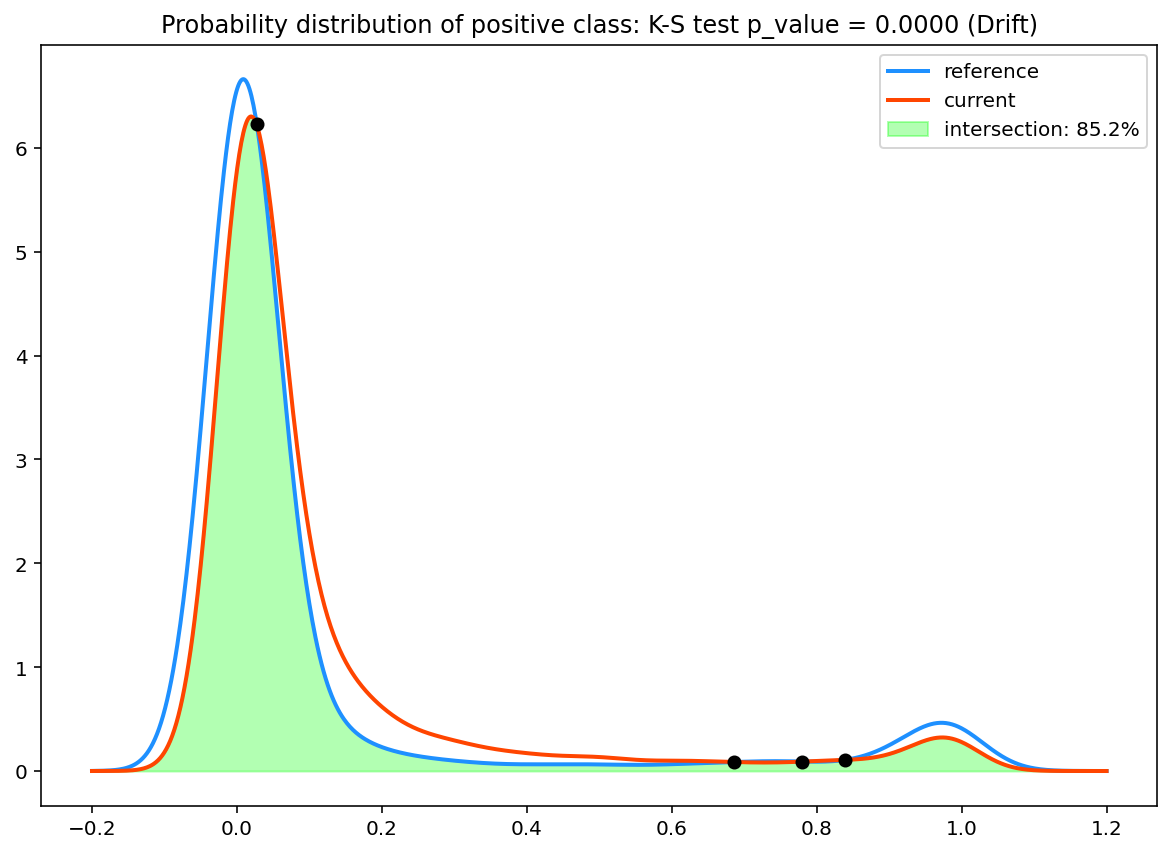

In [13]:
fig, ax = plt.subplots(figsize=(10,7))

plot_distribution_overlap(A = ref_arr, B = curr_arr, A_label = 'reference', B_label ='current', ax=ax)
ax.set_title(annot)

plt.show()


Finally, we have reused our KDE plots and statistical tests from the data drift section to measure the extend of the drift. The intersection between the KDE plots for both classifiers amount to less than 90%. Furthermore, the results of the KS test suggest that the distributions are not identical.
In this example, the results were to be expected because we intentionally built drift into our synthetic predictive maintenance dataset. With a real-world dataset, results won’t always be as obvious. Also, it might be necessary to try different reference and current window splits to reliably find model drift.


# Data drift identification as part of an AzureML MLOps Pipeline
We will now focus on embedding drift detection and mitigation in a MLOps architecture with Azure Machine Learning. The following section leverages concepts such as Azure ML Datasets, Models and Pipelines. The following code provides an example of an Azure ML pipeline for generating the data drift detection plots.

An Azure account with an active subscription is needed to run the following cells. [Create an account for free](https://azure.microsoft.com/en-us/free/).

## Create a new Azure ML Workspace
If the Workspace already exists, it will be reused.

In [14]:
from azureml.core import Workspace

ws = Workspace.create(name='myworkspace',
            subscription_id='<enter your Azure subscription ID>',
            resource_group='myresourcegroup',
            create_resource_group=True,
            location='westeurope',
            exist_ok=True)

## Provision a new Azure ML Compute Cluster

In [15]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4,
                                                           location='westeurope')
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Upload predicitve maintenance sample data to datastore

In [ ]:
# local data to be uploaded to the datastore
data_folder = './data/'
filename_A = 'reference_pred_maintenance.csv'
filename_B = 'current_pred_maintenance.csv'

# target in datastore
datastore_path = 'amldatasets/pred_maintenance/'

# dataset infos
name_A = 'reference_pred_maintenance'
name_B = 'current_pred_maintenance'

description = 'Data drift testing dataset'
tags = {'Project' : 'pred_maintenance',
        'Format' : 'CSV'}

reference.to_csv(f"{data_folder}{filename_A}", index=False)
current.to_csv(f"{data_folder}{filename_B}", index=False)

# get default datastore
datastore = ws.get_default_datastore()

files = [os.path.join(data_folder, filename_A), os.path.join(data_folder, filename_B)]

# upload data file to AML datastore:
datastore.upload_files(files = files, 
                       target_path = datastore_path,
                       overwrite = True,
                       show_progress = True)

# register as AML dataset
dataset_A = Dataset.Tabular.from_delimited_files(path = (datastore, datastore_path + filename_A))

dataset_A.register(ws, 
                 name=name_A, 
                 description=description,
                 tags = tags,
                 create_new_version = True)


# register as AML dataset
dataset_B = Dataset.Tabular.from_delimited_files(path = (datastore, datastore_path + filename_B))

dataset_B.register(ws, 
                 name=name_B, 
                 description=description,
                 tags = tags,
                 create_new_version = True)

## Run an AML Experiment to test code on a remote compute instance

In [ ]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import RunConfiguration
from azureml.pipeline.core import Pipeline, PipelineParameter, PublishedPipeline, Schedule, ScheduleRecurrence
from azureml.pipeline.steps import PythonScriptStep
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration


#SET UP THE EXPERIMENT
exp_folder = './experiment'
compute_name = 'cpucluster'

# workspace = Workspace.from_config()   

# Create a Python environment for the experiment (from a .yml file)
env = Environment.from_conda_specification("experiment_env", f"{exp_folder}/environment_pipeline.yml")

script_params = [
    '--reference_dataset', "reference_pred_maintenance",
     '--current_dataset', "current_pred_maintenance",
     '--threshold', 0.01,
     '--shortlist', "None"]

# Create a script config
script_config = ScriptRunConfig(source_directory=exp_folder,
                                script='data_drift_pipeline.py',
                                environment=env,
                                compute_target = compute_name, 
                                arguments = script_params)

# submit the experiment
experiment = Experiment(ws, name = 'Data_Drift_Experiment')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion(show_output=False)

## Define an Azure ML Pipeline

In [ ]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import RunConfiguration
from azureml.pipeline.core import Pipeline, PipelineParameter, PublishedPipeline, Schedule, ScheduleRecurrence
from azureml.pipeline.steps import PythonScriptStep
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration

#SET UP THE EXPERIMENT
exp_folder = './experiment'
compute_name = 'cpucluster'

# Create a Python environment for the experiment (from a .yml file)
env = Environment.from_conda_specification("experiment_env", f"{exp_folder}/environment_pipeline.yml")

aml_run_config = RunConfiguration()
aml_run_config.environment = env

pipeline_parameters = {
     'reference_dataset': "reference_pred_maintenance",
     'current_dataset': "current_pred_maintenance",
     'threshold': 0.01,
     'shortlist': "None"}


# Step to run a Python script
step1 = PythonScriptStep(name = 'detect_data_drift',
                         source_directory = exp_folder,
                         script_name = 'data_drift_pipeline.py',
                        arguments=[
                            "--reference_dataset", PipelineParameter(name="reference_dataset", default_value=pipeline_parameters["reference_dataset"]),
                            "--current_dataset", PipelineParameter(name="current_dataset", default_value=pipeline_parameters["current_dataset"]),
                            "--threshold", PipelineParameter(name="threshold", default_value=pipeline_parameters["threshold"]),
                            "--shortlist", PipelineParameter(name="shortlist", default_value=pipeline_parameters["shortlist"]),
                                                     ],
                         runconfig = aml_run_config,
                         compute_target = 'cpucluster',
                         allow_reuse=False)

# Construct the pipeline
data_drift_pipeline = Pipeline(workspace = ws, steps = [step1])

# Create an experiment and run the pipeline
experiment = Experiment(workspace = ws, name = 'data_drift_analysis_pipeline')

pipeline_run = experiment.submit(data_drift_pipeline, pipeline_parameters=pipeline_parameters)

## Publish the Azure ML Pipeline

In [ ]:
# Publish the pipeline
published_pipeline = data_drift_pipeline.publish(name='detect_data_drift_pipeline',
                                                  description='Generic data drift pipeline',
                                                  version='1.0')

rest_endpoint = published_pipeline.endpoint
print(rest_endpoint)

##  Schedule the Azure ML Pipeline for regular execution

In [20]:
# Schedule pipeline for periodic intervals

monthly = ScheduleRecurrence(frequency='Month', interval=1)
pipeline_schedule = Schedule.create(ws, name='Monthly drift detection',
                                        description='Monthly data drift detection',
                                        pipeline_id=published_pipeline.id,
                                        experiment_name='detect_data_drift',
                                        recurrence=monthly)

In [ ]:
# list schedules
schedule = Schedule.list(ws) 
print(schedule)

## Clean up resources
<span style='color:Red'> Warning. The following cell deletes the Azure ML Workspace and its dependencies!  </span>

Note that the container registry and resource group are not deleted.

In [1]:
# Uncomment the following line to delete the Workspace and all related resources
# ws.delete(delete_dependent_resources=True, no_wait=False)